In [77]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,Annotated
from pydantic import BaseModel,Field
from dotenv import load_dotenv
import operator

In [78]:
load_dotenv()

True

In [79]:
model = ChatGroq(model="llama-3.1-8b-instant")

In [80]:
class Eval(BaseModel):
    feedback:str=Field(...,description="An honest and detailed feedback about the essay")
    score:int=Field(...,description="Score the essay out of 10",ge=0,le=10)

In [81]:
llm=model.with_structured_output(Eval)

In [82]:
essay=""""Cricket is one of the most popular and widely played sports globally, with a rich history that spans over two centuries. Originating in England in the 16th century, cricket has evolved into a complex and strategic game that requires skill, teamwork, and mental toughness. The game has been a source of entertainment, social bonding, and national pride for millions of people across the world.\n\n**History of Cricket**\n\nCricket's early history dates back to the 16th century in England, where it was played by English nobility as a form of entertainment. The first recorded match was played in 1598 at Guildford, Surrey. Over time, cricket spread to other parts of the world, including the British colonies in India, Australia, and the West Indies. The establishment of the Marylebone Cricket Club (MCC) in 1787 marked the beginning of organized cricket, with the development of standardized rules and regulations.\n\n**The Game of Cricket**\n\nCricket is a team sport played with a hard, leather-covered ball and a flat, long-handled bat. The game is divided into innings, with each team taking turns to bat and bowl. The batting team sends two batsmen to the field, who score runs by hitting the ball and running between the wickets. The bowling team, led by a bowler, aims to dismiss the batsmen by getting them out, either by hitting the ball or having them run out.\n\n**Types of Cricket**\n\nThere are several forms of cricket, including:\n\n* **Test Cricket**: A five-day match played between national teams, with each team playing two innings.\n* **One-Day Cricket**: A limited-overs match, where each team plays a single innings and has a limited number of overs (deliveries).\n* **Twenty20 Cricket**: A shorter version of the game, where each team plays a single innings and has a limited number of overs.\n\n**Cricket and Culture**\n\nCricket has played a significant role in shaping the culture and identity of many countries, particularly in the Indian subcontinent, the Caribbean, and the United Kingdom. Cricket has been a unifying force, bringing people together across different regions, languages, and cultures. The game has also been a source of national pride, with teams competing fiercely for international recognition and glory.\n\n**Impact of Cricket**\n\nCricket has had a significant impact on the world, both on and off the field. The game has:\n\n* **Economic Benefits**: Cricket has generated significant revenue for countries, through tourism, sponsorships, and broadcasting rights.\n* **Social Benefits**: Cricket has brought people together, fostering social bonding and community spirit.\n* **Cultural Exchange**: Cricket has facilitated cultural exchange between countries, with players and spectators influencing each other's traditions and customs.\n\n**Conclusion**\n\nCricket is a complex and strategic game that requires skill, teamwork, and mental toughness. With a rich history that spans over two centuries, cricket has evolved into a global sport, with a massive following and significant economic and social impact. As a source of entertainment, social bonding, and national pride, cricket continues to unite people across cultures and borders, promoting peace, understanding, and respect for the game and its players."""

In [83]:
prompt=f"rate this essay:{essay} out of 10 and give a feedback based on the language used"

In [84]:
llm.invoke(prompt)

Eval(feedback="The essay is well-structured and provides a comprehensive overview of cricket's history, game types, cultural significance, and impact. The language is formal and engaging, making it suitable for an academic or informative piece. However, some sentences could be rephrased for better clarity and concision. The conclusion effectively summarizes the main points and leaves the reader with a lasting impression. Overall, the essay demonstrates a good understanding of the subject matter and is well-written.", score=8)

In [85]:
class EvalState(TypedDict):
    essay:str
    language:str
    analysis:str
    clarity:str
    overall:str
    individual_scores:Annotated[list[int],operator.add]
    avg_score:float

In [86]:
graph=StateGraph(EvalState)

In [87]:
def eval_lang(state:EvalState):

    prompt=prompt=f"rate this essay:{state["essay"]} out of 10 and give a feedback based on the language used"
    output=llm.invoke(prompt)
    return {"language":output.feedback,"individual_scores":[output.score]}

In [88]:
def eval_analysis(state:EvalState):

    prompt=prompt=f"evalute the depth of analysis in this essay:{state["essay"]} out of 10 and give a feedback on it"
    output=llm.invoke(prompt)
    return {"analysis":output.feedback,"individual_scores":[output.score]}

In [89]:
def eval_thought(state:EvalState):

    prompt=prompt=f"evalute the clarity of thoughts in this essay:{state["essay"]} out of 10 and give a feedback on it"
    output=llm.invoke(prompt)
    return {"clarity":output.feedback,"individual_scores":[output.score]}

In [90]:
def final_eval(state:EvalState):
    prompt=f"""
        Based on the following feedback create a summarized feedback:
        language feedback:{state['language']}
        analysis feedback:{state['analysis']}
        clarity of though feedback:{state['clarity']}
"""
    feed=model.invoke(prompt).content

    avg=sum(state['individual_scores'])/len(state['individual_scores'])

    return {"overall":feed,"avg_score":avg}

In [91]:
graph.add_node("eval_lang",eval_lang)
graph.add_node("eval_analysis",eval_analysis)
graph.add_node("final_eval",final_eval)
graph.add_node("eval_thought",eval_thought)

In [92]:
graph.add_edge(START,"eval_lang")
graph.add_edge(START,"eval_analysis")
graph.add_edge(START,"eval_thought")
graph.add_edge("eval_lang","final_eval")
graph.add_edge("eval_analysis","final_eval")
graph.add_edge("eval_thought","final_eval")
graph.add_edge("final_eval",END)

In [93]:
workflow=graph.compile()

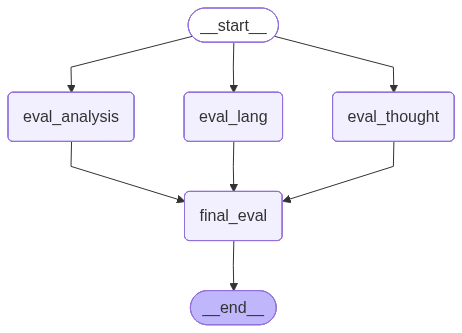

In [94]:
workflow

In [95]:
workflow.invoke({"essay":essay})

{'essay': '"Cricket is one of the most popular and widely played sports globally, with a rich history that spans over two centuries. Originating in England in the 16th century, cricket has evolved into a complex and strategic game that requires skill, teamwork, and mental toughness. The game has been a source of entertainment, social bonding, and national pride for millions of people across the world.\n\n**History of Cricket**\n\nCricket\'s early history dates back to the 16th century in England, where it was played by English nobility as a form of entertainment. The first recorded match was played in 1598 at Guildford, Surrey. Over time, cricket spread to other parts of the world, including the British colonies in India, Australia, and the West Indies. The establishment of the Marylebone Cricket Club (MCC) in 1787 marked the beginning of organized cricket, with the development of standardized rules and regulations.\n\n**The Game of Cricket**\n\nCricket is a team sport played with a ha